## BLADE six-input, one-output Boolean Logic Look Up Table (LUT)
QUEEN script for simulating sequence state alternations in the BLADE Boolean LUT.
In this circuit, upon input of site-specific DNA recombinases, the circuit DNA sequence alters by multi-step deletions and/or inversions of segments sandwiched by corresponding recombinase target sequences. The input patterns of four recombinases (Vica, B3, PhiC31, and Bxb1) configures one of the 16 Boolean logic gates where the remaining two recombinases (Cre and FLP) serve as two input signals to the logic gate. The output is given as GFP expression derived by the promoter located upstream of the circuit DNA. The intertwined segment recombinations yield one or none of the four GFP genes to be expressed, depending on the signal input pattern.

In [1]:
%matplotlib inline
import sys
import copy
import collections
from QUEEN.queen import *
set_namespace(globals()) 
if "output" not in os.listdir("./"):
    os.mkdir("output")

In [2]:
#Add the reocombination sites of Phic31, Bxb1, Vika, B3, Cre, Flpe. to "cs.lib". 
from QUEEN import cutsite as cs 
cs.lib["attB_PhiC31"] = "GTGCGGGTGCCAGGGCGTGCCC^TT_GGGCTCCCCGGGCGCGTACTCC"
cs.lib["attP_PhiC31"] = "ACGCCCCCAACTGAGAGAACTC^AA_AGGTTACCCCAGTTGGGGCACT"
cs.lib["attB_Bxb1"]   = "TCGGCCGGCTTGTCGACGACGGCG^GT_CTCCGTCGTCAGGATCATCCGGGC"
cs.lib["attP_Bxb1"]   = "GGGTTTGTACCGTACACCACTGAG^AC_CGCGGTGGTTGACCAGACAAACCACGA"
cs.lib["vox"]         = "AATAGGTCTGAGAA^CGCCCA_TTCTCAGACGTATT"
cs.lib["B3RT"]        = "GGTTGCTTAAGAAT^AAGTA_ATTCTTAAGCAACC"
cs.lib["loxP"]        = "ATAACTTCGTATAA^TGTATG_CTATACGAAGTTAT"
cs.lib["lox2272"]     = "ATAACTTCGTATAA^AGTATC_CTATACGAAGTTAT"
cs.lib["FRT"]         = "GAAGTTCCTATTC^TCTAGAAA_GTATAGGAACTTC"

In [3]:
LUT_original = cropdna(QUEEN(record="input/addgene_87554_attachment.gbk"), 2794, 10915) #Load pBW829_pCAG-pExpr-LUT plasmid object and crop the sequence region of Boolean Logic LUT.
LUT_original.outputgbk("output/LUT.gbk", record_id="Boolean_Logic_LUT")                 #Generate a gbk file of the seqeunce region of Boolean Logic LUT.
LUT = QUEEN(record="output/LUT.gbk", import_history=False)                              #Create a QUEEN object by loading the gbk file.

In [4]:
#Provide sequence features to the circuit.
feature_labels = ["FRT", "loxP", "lox2272", "GFP-1", "GFP-2", "GFP-3", "GFP-4", "attB \(PhiC31\)", "attP \(PhiC31\)", "vox","B3RT", "attB \(Bxb1\)", "attP \(Bxb1\)", "NeoR-1", "NeoR-2", "pA"]
rsite_color_dict = {"FRT":"#30458e", "loxP":"#e41a1c", "lox2272":"#8600d4", "attB \(PhiC31\)":"#e34397", r"attP \(PhiC31\)":"#e34397", "vox":"#21a0db", "B3RT":"#b5b521", r"attB \(Bxb1\)":"#a65628", r"attP \(Bxb1\)":"#a65628"}

feat_ids = [] 
for label in feature_labels:
    feat_ids.extend([feat.feature_id for feat in LUT.searchfeature(query=".*" + label, key_attribute="qualifier:label")]) #Search for seqeunce features that have "label" in qualifier:label.

    if "GFP" in label:
        #Set qualifier values for the visualization of GFP genes.
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelweight_queen", operation=createattribute('bold'),    new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:edgecolor_queen",   operation=createattribute("#777777"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:facecolor_queen",   operation=createattribute("#777777"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#CCCCCC"), new_copy=False)

    elif "pA" in label:
        #Set qualifier values for the visualization of pA signal sequences.
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelweight_queen", operation=createattribute('bold'),    new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:edgecolor_queen",   operation=createattribute("#909090"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:facecolor_queen",   operation=createattribute("#909090"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#FFFFFF"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:label",             operation=replaceattribute("T"),      new_copy=False) #Change the label of pA signal to "T".
    
    elif "Neo" in label:
        #Set qualifier values for the visualization of neomycin resistance genes.
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelweight_queen", operation=createattribute("normal"),  new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:edgecolor_queen",   operation=createattribute("#000000"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:facecolor_queen",   operation=createattribute("#FFFFFF"), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#000000"), new_copy=False)
    else:
        #Set qualifier values for the visualization of recombinations sites.
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelweight_queen", operation=createattribute('bold'),                  new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:edgecolor_queen",   operation=createattribute(rsite_color_dict[label]), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:facecolor_queen",   operation=createattribute(rsite_color_dict[label]), new_copy=False)
        editfeature(LUT, key_attribute="qualifier:label", query=label, target_attribute="qualifier:labelcolor_queen",  operation=createattribute("#FFFFFF"),               new_copy=False)
feat_ids = set(feat_ids)

feature_id  feature_type  qualifier:label  start  end   strand  
2500        misc_feature  T                6115   6652  +       
1300        misc_feature  T                2577   2718  +       
700         misc_feature  attP (PhiC31)    1387   1433  -       
3200        misc_feature  attP (Bxb1)      8068   8121  -       
1800        misc_feature  FRT              4086   4120  +       
2100        CDS           NeoR-2           4236   5031  +       
300         misc_feature  attB (PhiC31)    75     121   +       
600         CDS           GFP-1            658    1378  -       
1400        misc_feature  vox              2726   2760  +       
2800        misc_feature  attB (Bxb1)      6752   6802  +       
500         misc_feature  T                121    658   -       
2300        misc_feature  B3RT             5353   5386  +       
2200        misc_feature  T                5204   5345  +       
2400        CDS           GFP-3            5395   6115  +       
2000        misc_feature 

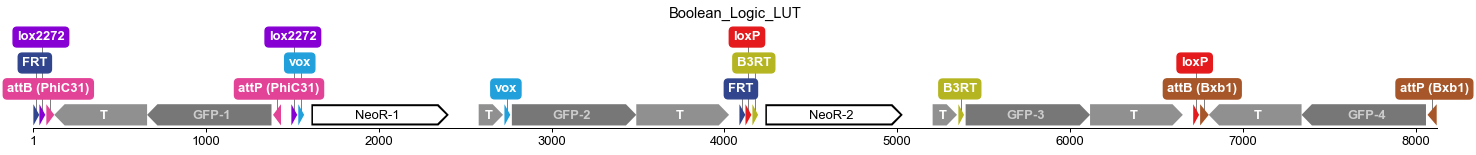

In [5]:
features = sum([LUT.searchfeature(query="^" + _id + "$", key_attribute="feature_id") for _id in feat_ids],[]) #Search features to be visualized in the sequence map.
LUT.printfeature(feature_list=features) 
fig = visualizemap(LUT, feature_list=features, label_location='both', fontsize=13, tick_interval=1000, display_label=2, width_scale=0.8, height_scale=1.2, labelcolor="w")
fig.savefig("output/LUT.png", bbox_inches="tight", dpi=200)

In [6]:
def select_logic_gate(lut, s1, s2, s3, s4, logic):
    
    #Configure the logic gate according to the combinations s1 (PhiC31), s2 (Vika), s3 (B3), and s4 (Bxb1).
    ip = 0 
    if s1 == 1:

        #Sequnece state chage induced by PhiC31.
        ip   += 1
        pn    = "Phic31-attB/P inversion"
        pd    = "Invert sequence between attB/P(PhiC31). ({},{},{},{})".format(s1, s2, s3, s4) 
        state = "{}_IP{}".format(logic, ip) if 1 in (s2,s3,s4) else logic                                             #Define intermediate product name.
        lut.searchsequence(cs.lib["attB_PhiC31"], product="attB_PhiC31", pn=pn, pd=pd)                                #Search for attB_PhiC31 site.
        lut.searchsequence(cs.lib["attP_PhiC31"], product="attP_PhiC31", pn=pn, pd=pd)                                #Search for attP_PhiC31 site.
        IP  = cutdna(lut, attB_PhiC31[0], attP_PhiC31[0], product=state + "_fragments".format(logic, ), pn=pn, pd=pd) #Cut the LUT object at the cut sites.
        lut = joindna(IP[0], flipdna(IP[1], pn=pn, pd=pd), IP[2], product=state, pn=pn, pd=pd)                        #Invert the second fragment and rejoin it with the rest.

    if s2 == 1: 
        #Sequnece state chage induced by Vika.
        ip   += 1
        pn    = "Vika-vox excision" 
        pd    = "Excise sequence between vox sites. ({},{},{},{})".format(s1, s2, s3, s4) 
        state = "{}_IP{}".format(logic, ip) if 1 in (s3,s4) else logic                    #Define intermediate product name.
        lut.searchsequence(cs.lib["vox"], product="vox", pn=pn, pd=pd)                    #Search for vox sites.
        IP    = cutdna(lut, *vox, product=state+"_fragments", pn=pn, pd=pd)               #Cut the LUT object at vox sites.
        lut = joindna(IP[0], IP[2], product=state, pn=pn, pd=pd)                          #Join the fragments without the second fragment.
    
    if s3 == 1:
        #Sequnece state chage induced by B3.
        ip   += 1
        pn    = "B3-B3RT excision" 
        pd    = "Excise sequence between B3RT sites. ({},{},{},{})".format(s1, s2, s3, s4) 
        state = "{}_IP{}".format(logic, ip) if 1 == s4 else logic            #Define intermediate product name.
        lut.searchsequence(cs.lib["B3RT"], product="B3RT", pn=pn, pd=pd)     #Search for B3RT sites.
        IP    = cutdna(lut, *B3RT, product=state+"_fragments", pn=pn, pd=pd) #Cut the LUT object at B3RT sites.
        lut   = joindna(IP[0], IP[2], product=state, pn=pn, pd=pd)           #Join the fragments without the second fragment.
    
    if s4 == 1:
        #Sequnece state chage induced by Bxb1.
        ip   += 1
        pn    = "Bxb1-attB/P inversion" 
        pd    = "Invert sequence between attB/P(Bxb1). ({},{},{},{})".format(s1, s2, s3, s4) 
        state = logic
        lut.searchsequence(cs.lib["attB_Bxb1"], product="attB_Bxb1", pn=pn, pd=pd)                                  #Search for attB_Bxb1 site.
        lut.searchsequence(cs.lib["attP_Bxb1"], product="attP_Bxb1", pn=pn, pd=pd)                                  #Search for attP_Bxb1 site.
        IP  = cutdna(lut, attB_Bxb1[0], attP_Bxb1[0], product=state+"_fragments".format(logic, ip+1), pn=pn, pd=pd) #Cut the LUT object at the cut sites.
        lut = joindna(IP[0], flipdna(IP[1], pn=pn, pd=pd), IP[2], product=state, pn=pn, pd=pd)                      #Invert the second fragment and rejoin it with the rest.
    return lut

In [7]:
#Simulate the different configurations of the Boolean LUT.
argments_set=[(0,1,1,1,"OR"), 
              (1,0,0,0,"NOR"), 
              (0,0,0,1,"AND"), 
              (1,1,1,0,"NAND"), 
              (0,1,0,1,"A"), 
              (0,0,1,1,"B"), 
              (1,0,1,0,"NOT_A"), 
              (1,1,0,0,"NOT_B"), 
              (1,0,1,1,"A_IMPLY_B"),
              (1,1,0,1,"B_IMPLY_A"),
              (0,1,0,0,"A_NIMPLY_B"),
              (0,0,1,0,"B_NIMPLY_A"),
              (0,1,1,0,"XOR"),
              (1,0,0,1,"XNOR"),
              (1,1,1,1,"TRUE"),
              (0,0,0,0,"FALSE")]
gates = []
for arguments in argments_set:
    print(arguments)
    gate = select_logic_gate(LUT, *arguments) #Configure a specified logic gate.
    gates.append(gate)

(0, 1, 1, 1, 'OR')
(1, 0, 0, 0, 'NOR')
(0, 0, 0, 1, 'AND')
(1, 1, 1, 0, 'NAND')
(0, 1, 0, 1, 'A')
(0, 0, 1, 1, 'B')
(1, 0, 1, 0, 'NOT_A')
(1, 1, 0, 0, 'NOT_B')
(1, 0, 1, 1, 'A_IMPLY_B')
(1, 1, 0, 1, 'B_IMPLY_A')
(0, 1, 0, 0, 'A_NIMPLY_B')
(0, 0, 1, 0, 'B_NIMPLY_A')
(0, 1, 1, 0, 'XOR')
(1, 0, 0, 1, 'XNOR')
(1, 1, 1, 1, 'TRUE')
(0, 0, 0, 0, 'FALSE')


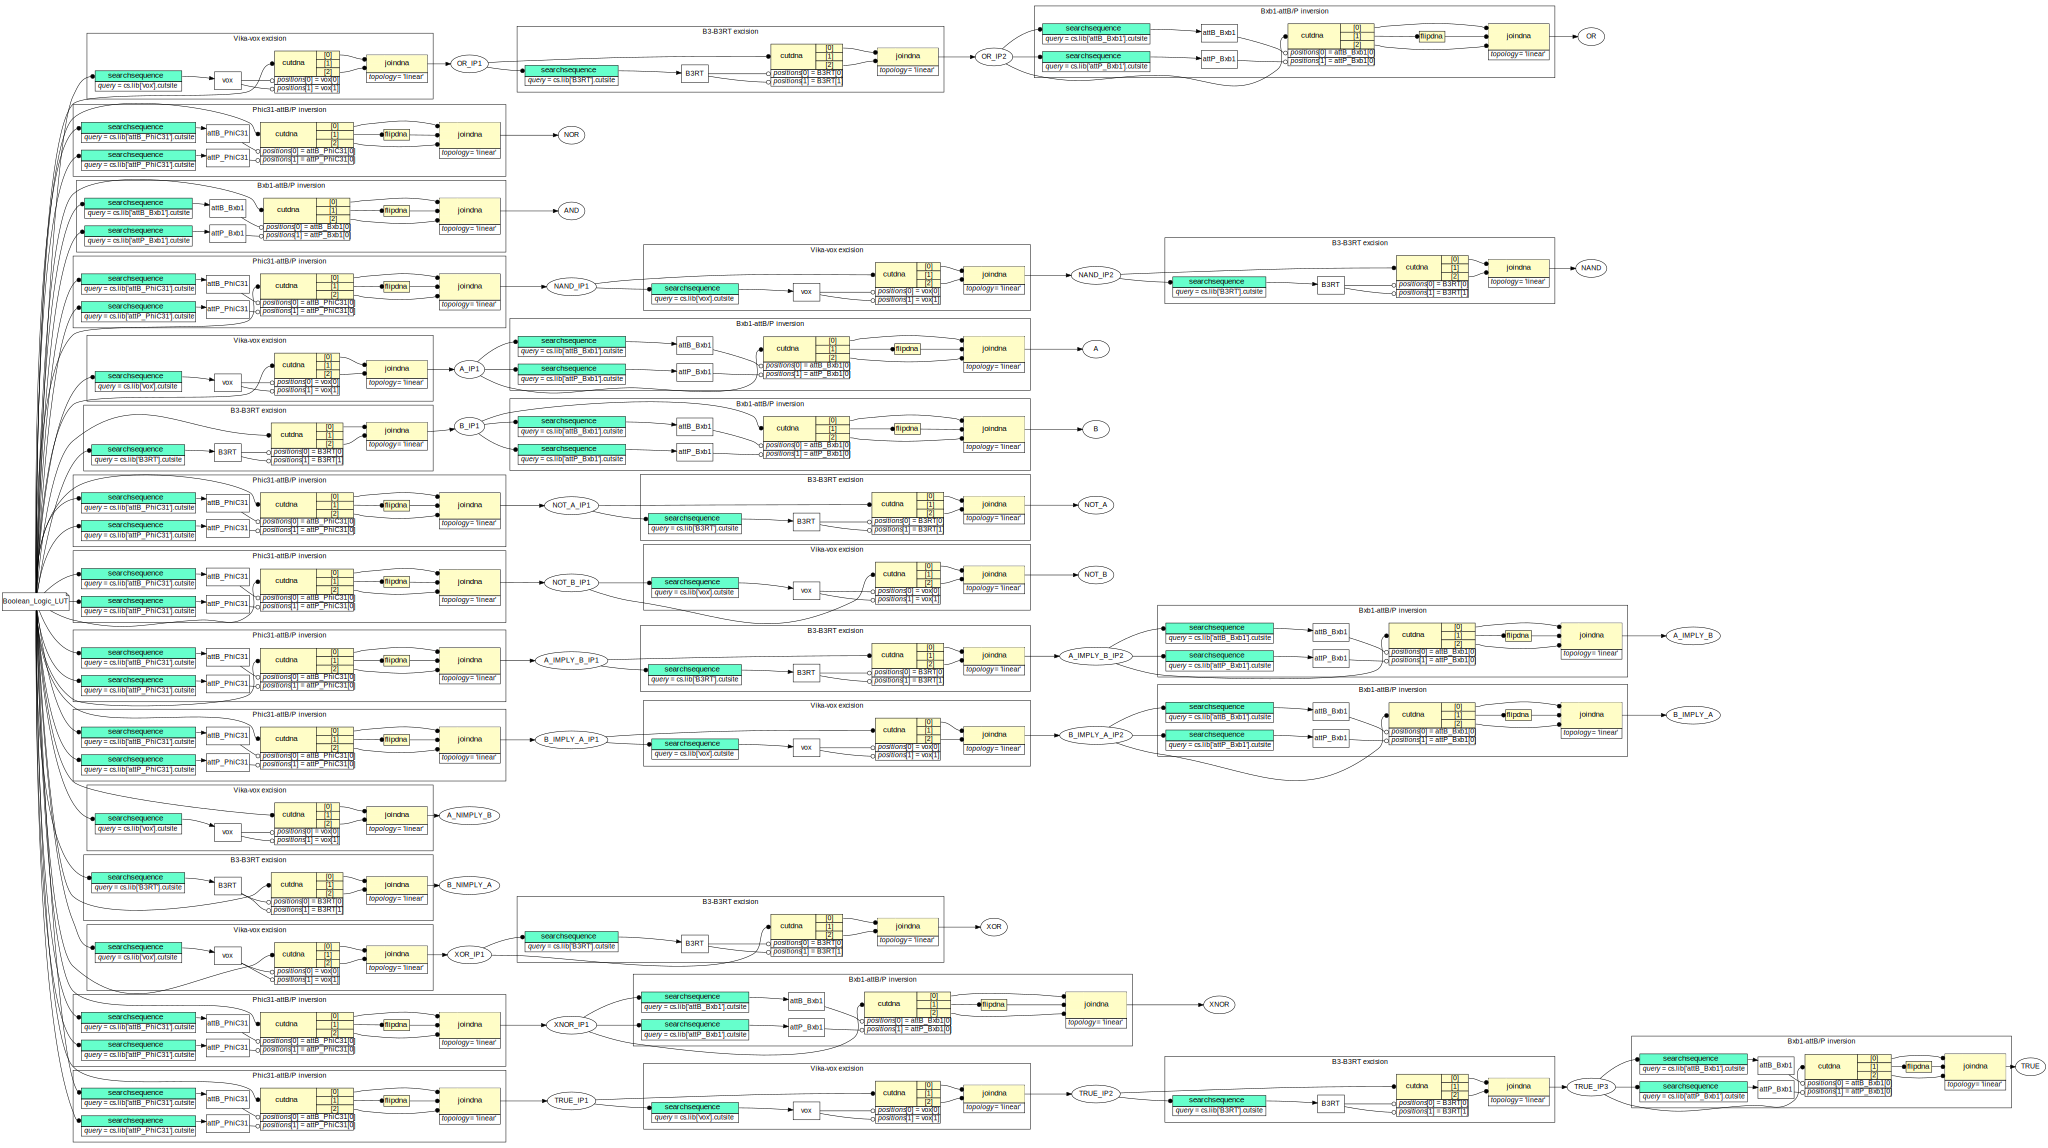

In [8]:
#Visualize the different configuration flows of the Boolean LUT.
g = visualizeflow(*gates) 
g.render("output/LUT_logic_flow_all")
g

In [9]:
def stimulate(gate, a, b, gatename): 
    #Compute "gate" with the inputs "a" and "b".

    gate_input = gatename + "{}{}".format(a,b)
    if a == 1:
        
        #Sequnece state chage induced by Cre.
        num = 0 
        pn1 = "Cre-loxP excision" 
        pd1 = "Excise seqeunce between loxP sites" 
        pn2 = "Cre-lox2272 excision" 
        pd2 = "Excise seqeunce between lox2272 sites" 
        
        gate.searchsequence(cs.lib["loxP"], product="loxP")       #Search for loxP sites.
        gate.searchsequence(cs.lib["lox2272"], product="lox2272") #Search for lox2272 sites.
        
        if len(loxP) == 2:                                                                                                   #If the number of loxP sites are 2
            gate.searchsequence(cs.lib["loxP"], product="loxP", pn=pn1, pd=pd1)                                              #Search for loxP sites.
            state = "gate_IP" + str(num) if (b == 1 or len(lox2272) == 2) else gate_input                                    #Define intermediate product name.
            gate  = joindna(cutdna(gate, *loxP, product="IP1", pn=pn1, pd=pd1)[0], IP1[2], product=state, pn=pn1, pd=pd1)    #Cut the LUT object at the cut sites and join the fragments without the second fragment.
            num += 1
        
        if len(lox2272) == 2:                                                                                                #If the number of loxP sites are 2
            gate.searchsequence(cs.lib["lox2272"], product="lox2272", pn=pn2, pd=pd2)                                        #Search for lox2272 sites.
            state = "gate_IP" + str(num) if b == 1 else gate_input                                                           #Define intermediate product name.
            gate  = joindna(cutdna(gate, *lox2272, product="IP2", pn=pn2, pd=pd2)[0], IP2[2], product=state, pn=pn2, pd=pd2) #Cut the LUT object at the cut sites and join the fragments without the second fragment.
    
    if b == 1:
        #Sequnece state chage induced by Flp.
        pn = "Flpe-FRT excision" 
        pd = "Excise seqeunce between FRT sites"

        gate.searchsequence(cs.lib["FRT"], product="FRT", pn=pn, pd=pd) #Search for FRT sites.
        if len(FRT) == 2: #If the number of FRT sites are 2
            gate = joindna(cutdna(gate, *FRT, product="IP3", pn=pn, pd=pd)[0], IP3[2], product=gate_input, pd=pd, pn=pn)    #Cut the LUT object at the cut sites and join the fragments without the second fragment.
    return gate
    
def check_gfp_states(gate):

    #Check expresion status of each GFP gene in the output.
    visible_features = [] 
    gate = copy.deepcopy(gate) 
    gfps = gate.searchfeature(query="GFP", key_attribute="qualifier:label") #Search for GFP genes.
    for gfp in gfps:
        pAs = gate.searchfeature(query="^T$", key_attribute="qualifier:label", start=0, end=gfp.start) #Search for T (terminator) located upstream of a target GFP.
        if len(pAs) > 0 or gfp.strand == -1:                                                           #If T is found to be upstream of the target GFP or the GFP is coded in the minus strand

            #GFP is inactivated
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:edgecolor_queen", operation=replaceattribute("#777777"),  new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:facecolor_queen", operation=replaceattribute("#777777"),  new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:labelcolor_queen", operation=replaceattribute("#CCCCCC"), new_copy=False)
        else:

            #GFP is activated
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:edgecolor_queen", operation=replaceattribute("#66FF00"),  new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:facecolor_queen", operation=replaceattribute("#66FF00"),  new_copy=False)
            editfeature(gate, query=gfp.feature_id, key_attribute="feature_id", target_attribute="qualifier:labelcolor_queen", operation=replaceattribute("#303030"), new_copy=False)
    return gate

def getfeatures(gate, sites):
    
    #Obtain seqeunce features of "sites" to be visualized for "gate".
    visible_features = [] 
    for label in sites:
        if "pA" in label:
          features = gate.searchfeature(query="^T$", key_attribute="qualifier:label")
        else:
          features = gate.searchfeature(query=label, key_attribute="qualifier:label")
        for feat in features:
            if "broken_feature" in feat.qualifiers:
                pass
            else: 
                visible_features.append(feat)
    return visible_features

In [10]:
#Simulate the configured logic gates with two inputs Cre and Flp.  
for gate in gates:
    gatename = gate.project 
    features = getfeatures(gate, feature_labels)

    gate = check_gfp_states(gate)
    features = getfeatures(gate, feature_labels)
    fig  = visualizemap(gate, feature_list=features, label_location='both', fontsize=11, tick_interval=1000, title="", display_axis=False, display_label=1, width_scale=0.43, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate.project), bbox_inches="tight")
    gate.outputgbk("output/" + gate.project + "_00" + ".gbk")

    gate01 = stimulate(gate, 1, 0, gatename)
    gate01 = check_gfp_states(gate01)
    features = getfeatures(gate01, feature_labels)
    fig = visualizemap(gate01, feature_list=features, label_location='both', fontsize=11, tick_interval=1000, title="", display_axis=False, display_label=1, width_scale=0.43, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate01.project), bbox_inches="tight")
    gate01.outputgbk("output/" + gate.project + "_10" +  ".gbk")
    
    gate10 = stimulate(gate, 0, 1, gatename)
    gate10 = check_gfp_states(gate10)
    features = getfeatures(gate10, feature_labels)
    fig = visualizemap(gate10, feature_list=features, label_location='both', fontsize=11, tick_interval=1000, title="", display_axis=False, display_label=1, width_scale=0.43, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate10.project), bbox_inches="tight")
    gate10.outputgbk("output/" + gate.project + "_01" + ".gbk")

    gate11 = stimulate(gate, 1, 1, gatename)
    gate11 = check_gfp_states(gate11)
    features = getfeatures(gate11, feature_labels)
    fig = visualizemap(gate11, feature_list=features, label_location='both', fontsize=11, tick_interval=1000, title="", display_axis=False, display_label=1, width_scale=0.43, height_scale=0.8, labelcolor="w")   
    fig.savefig("output/{}.pdf".format(gate11.project), bbox_inches="tight")
    gate11.outputgbk("output/" + gate.project + "_11" + ".gbk")
    print(gate)

<queen.QUEEN object; project='OR', length='5736 bp', topology='linear'>
<queen.QUEEN object; project='NOR', length='8121 bp', topology='linear'>
<queen.QUEEN object; project='AND', length='8121 bp', topology='linear'>
<queen.QUEEN object; project='NAND', length='5736 bp', topology='linear'>
<queen.QUEEN object; project='A', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='B', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='NOT_A', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='NOT_B', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='A_IMPLY_B', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='B_IMPLY_A', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='A_NIMPLY_B', length='6928 bp', topology='linear'>
<queen.QUEEN object; project='B_NIMPLY_A', length='6929 bp', topology='linear'>
<queen.QUEEN object; project='XOR', length='5736 bp', topology='linear'>
<queen.QUEEN object; proj